# Photon propagation

Photons can be propagated as individual particles with Eleca (suitable for high energies), or the resulting spectra can be calculated with DINT (suitable for low energies). Alternatively a combined module is available that processes high energy photons with Eleca and the calcualtes the resulting spectra with DINT down to low energies. The propagation of photons is currently possible only in 1D and is not integrated into the CRPpropa module-chain. Instead,  photons are read in from an external file.

The file "photon_monoenergetic_source.dat" contains 1000 photons with E = 50 EeV from a photon source in 4 Mpc distance.

## Propagation with Dint


In [4]:
import crpropa

crpropa.DintPropagation("photon_monoenergetic_source.dat", "spectrumDINT.dat", 0.1 * 1E-9 * crpropa.gauss, 4, 4)



## Propagation with Eleca


In [5]:
import crpropa

crpropa.EleCaPropagation("photon_monoenergetic_source.dat", "eleca_photons.dat", True, 1E17*crpropa.eV, 0.1 * 1E-9 * crpropa.gauss)



## Combined Propagation

In [6]:
import crpropa

crpropa.DintElcaPropagation("photon_monoenergetic_source.dat", "dintElca_spectrum.dat", True, .5 * crpropa.EeV, 0.1 * 1E-9 * crpropa.gauss)


## (Optional) Plotting of Results

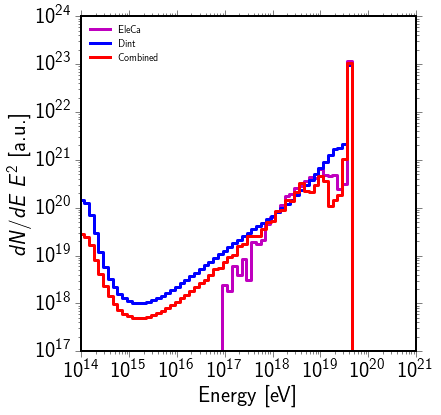

In [7]:
%matplotlib inline
from pylab import *

figure(figsize=(6,6))

loglog(clip_on=False)
yscale("log", nonposy='clip')
xlabel('Energy [eV]')
ylabel ('$dN/dE\; E^2$  [a.u.]')

# define bins
binEdges = 10**arange(12, 24, .1)
logBinCenters = log10(binEdges[:-1]) + 0.5 * (log10(binEdges[1:]) - log10(binEdges[:-1]))
binWidths = (binEdges[1:] - binEdges[:-1])

#load eleca photons
elecaPhotons = loadtxt("eleca_photons.dat")
data = histogram(elecaPhotons[:,1] * 1E18, bins=binEdges)

#calculate spectrum
J = data[0] / binWidths
dJ = J / sqrt(data[0])
E = 10**logBinCenters
step(E, J * E**2,  c='m', label='EleCa')

#Plot the dint spectrum
dataDINT = loadtxt("spectrumDINT.dat")
E = dataDINT[:,0] * 1E18 
J = dataDINT[:,2] / (dataDINT[:,1] * 1E18)
step(E, J * E**2 , c='b', ls='-', where='mid', label='Dint')


#Plot the dintelca spectrum
dataDINTElca = loadtxt("dintElca_spectrum.dat")
E = dataDINTElca[:,0] * 1E18 
J = dataDINTElca[:,2] / (dataDINTElca[:,1] * 1E18)
step(E, J *E**2 , c='r', ls='-', where='mid', label='Combined')

# Nice limits
xlim(1e14, 1E21)
ylim(ymin=1E17)
legend(loc='upper left')





## Photons from Proton Propagation

The generaton of photons has to be enabled for the individual energy-loss processes in the module chain. Also, a photon output module has to be added:

In [ ]:
from crpropa import *   

# source setup  
source = Source()       
source.add(SourceParticleType(nucleusId(1, 1))) 
source.add(SourcePowerLawSpectrum(10 * EeV, 100 * EeV, -2))     
source.add(SourceUniform1D(3 * Mpc, 100.00001 * Mpc))   

#Setup module list for proton propagation
m = ModuleList()        
m.add(SimplePropagation(0, 10 * Mpc))
m.add(MinimumEnergy(1 * EeV))   
m.add(Observer1D())     
m.add(EventOutput1D("proton_output.txt"))       

# Secondary electrons are disabled here
m.add(ElectronPairProduction(CMB, False))        
# Enable secondary photons
m.add(PhotoPionProduction(CMB, True))   

# add a photon output
m.add(PhotonOutput1D("photon_output.txt"))

# run simulation        
m.run(source, 10000, True)

The file 'photon_output' will contain approximately 600 secondary particles, half of them photons and can be processed as the photon example above.